# Tohoku tsunami inversion
## Inversion using continuous adjoint with a regularisation term

In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import scipy
from time import clock

In [3]:
from thetis import *

In [4]:
from adapt_utils.case_studies.tohoku.options import TohokuOptions
from adapt_utils.norms import total_variation
from adapt_utils.misc import gaussian, ellipse

_[Misc plotting functions]_

In [5]:
def plot_field(field, figure=None, axes=None, height=5, **kwargs):
    CG1 = field.ufl_element().degree() == 1 and field.ufl_element().family() == 'Lagrange'
    fs_constructor = FunctionSpace if len(field.function_space().shape) == 0 else VectorFunctionSpace
    out = field if CG1 else interpolate(field, fs_constructor(field.function_space().mesh(), "CG", 1))
    
    if figure is None and axes is None:
        figure, axes = plt.subplots(figsize=(height*1.2, height))
    if axes is None:
        axes = plt.gca()
    figure.colorbar(tricontourf(out, levels=50, axes=axes, cmap='coolwarm', **kwargs), ax=axes);
    axes.axis(False);
    axes.set_title(field.dat.name);
    return axes

In [6]:
def plot_fields(*fields, height=5):
    nfields = len(fields)
    fig, axes = plt.subplots(ncols=nfields, figsize=(height*nfields*1.2, height))
    for i, field in enumerate(fields):
        try:
            plot_field(field, fig, axes[i])
        except AttributeError:
            plot_mesh(field, fig, axes[i])
    return axes

In this hacky implementation we use some global variables

In [7]:
global level
level = 0

global op
op = TohokuOptions(level=level)
op.gauges.pop('21418')  # This pressure gauge isn't within the domain

global mesh
mesh = op.default_mesh

global diffs
diffs = [None for i in range(int(op.end_time/op.dt)+1)]

global boundary_conditions
boundary_conditions = {
    100: ['freeslip', 'dirichlet'],
    200: ['freeslip'],
    300: ['freeslip'],
}

global basis_centres
basis_centres = [(0.7e+06, 4.2e+06), ]

### Forward model

As before, consider the shallow water equations linearised about lake at rest:

$$
    \frac{\partial\mathbf u}{\partial t}+g\nabla\eta+f\widehat{\mathbf z}\times\mathbf u=\boldsymbol0,\qquad
    \frac{\partial\eta}{\partial t}+\nabla\cdot(b\mathbf u)=0,\qquad
    \text{in}\quad(0,T]\times\Omega,
$$

equipped with boundary conditions

$$
    \mathbf u\cdot\widehat{\mathbf n}|_{\Gamma_{\mathrm{freeslip}}}\equiv0,\qquad
    \eta|_{\Gamma_D}\equiv0.
$$

Assume zero initial velocity and expand the initial surface over a radial basis:

$$
    \mathbf u|_{t=0}\equiv\boldsymbol0,\qquad
    \eta|_{t=0}=\sum_{k=1}^N m_kg_k,
$$

where $m_k$ are (constant in space) control parameters and $g_k$ are Gaussians.

Choose an initial guess for the basis coefficient

In [8]:
m0 = 10.0

In [9]:
def get_fields(fs):
    elev_space = fs.sub(1)
    b = Function(elev_space, name="Bathymetry (from GEBCO)").assign(op.set_bathymetry(elev_space))
    f = Function(elev_space, name="Coriolis parameter").assign(op.set_coriolis(elev_space))
    g = Constant(op.g)
    return b, f, g

### Quantity of Interest

Modify the QoI with a regularisation term

$$
J(\mathbf u,\eta)=\frac12\sum_{g\in\mathcal G}\int_0^T\int_\Omega\mathbb1_g\big(\:\eta(x,t)-\eta_g(t)\:\big)^2\;\mathrm dx\;\mathrm dt
+\mathcal R,
$$

where $\mathbb1_g$ is an indicator function related to a sufficiently small neighbourhood of gauge $g$ and $\sigma>0$ is the regularisation parameter.
We have
$$
    \int_\Omega\frac\sigma2\nabla\eta_0\cdot\nabla\eta_0\;\mathrm dx.
$$

Note that

$$
    \mathcal R=\int_\Omega\frac\sigma2\left(\sum_{k=1}^Nm_k\nabla g_k\right)\cdot\left(\sum_{k=1}^Nm_k\nabla g_k\right)\;\mathrm dx
    \quad\implies\quad
    \frac{\partial\mathcal R}{\partial m_k}=
    \int_\Omega\sigma m_k\nabla g_k\cdot\nabla g_k\;\mathrm dx.
$$

In [10]:
global sigma
sigma = Constant(1.0e+11)

In [11]:
def sampled_timeseries(g, sample=1):
    time_prev = 0.0
    num_lines = sum(1 for line in open('resources/gauges/{:s}.dat'.format(g), 'r'))
    t, d, running = [], [], []
    with open('resources/gauges/{:s}.dat'.format(g), 'r') as f:
        for i in range(num_lines):
            time, dat = f.readline().split()
            time, dat = float(time), float(dat)
            if np.isnan(dat):
                continue
            running.append(dat)
            if i % sample == 0 and i > 0:
                t.append(0.5*(time + time_prev))
                d.append(np.mean(running))
                running = 0
                time_prev = time
                running = []
    return scipy.interpolate.interp1d(t, d, bounds_error=False, fill_value='extrapolate')

In [12]:
def get_basis_functions(fs, xy_skew=(48e+03, 96e+03), angle=pi/12):
    basis_functions = []
    for loc in basis_centres:
        basis_function = Function(fs)
        psi, phi = basis_function.split()
        phi.interpolate(gaussian([loc + xy_skew, ], fs.mesh(), rotation=angle))
        basis_functions.append(basis_function)
    return basis_functions

In [13]:
def print_debug(msg, debug=False):
    if debug:
        print(msg)

In [14]:
def solve_forward(ctrl_dat, gradient=False, debug=True):
    print("FORWARD SOLVE FOR GRADIENT CALCULATION" if gradient else "FORWARD SOLVE")
    if isinstance(ctrl_dat, float):
        ctrl_dat = [ctrl_dat, ]
    print_debug("Current control value = {:.8e}".format(*ctrl_dat), debug=debug)
    
    # --- Setup function spaces
    
    fs = VectorFunctionSpace(mesh, "CG", 2)*FunctionSpace(mesh, "CG", 1)
    P0 = FunctionSpace(mesh, "DG", 0)
    
    # -- Setup fields
    
    b, f, g = get_fields(fs)
    
    # --- Setup PDE
    
    dtc = Constant(op.dt)
    
    u, eta = TrialFunctions(fs)
    z, zeta = TestFunctions(fs)

    q_ = Function(fs)
    u_, eta_ = q_.split()

    a = inner(z, u)*dx + inner(zeta, eta)*dx
    L = inner(z, u_)*dx + inner(zeta, eta_)*dx
    
    n = FacetNormal(mesh)

    def G(uv, elev):
        F = g*inner(z, grad(elev))*dx
        F += f*inner(z, as_vector((-uv[1], uv[0])))*dx
        F += -inner(grad(zeta), b*uv)*dx
        for tag in boundary_conditions:
            if 'freeslip' not in boundary_conditions[tag]:
                F += inner(zeta*n, b*uv)*ds(tag)
        return F

    a += 0.5*dtc*G(u, eta)
    L += -0.5*dtc*G(u_, eta_)

    q = Function(fs)
    u, eta = q.split()

    bcs = []
    for tag in boundary_conditions:
        if 'dirichlet' in boundary_conditions[tag]:
            bcs.append(DirichletBC(fs.sub(1), 0, tag))

    params = {
        "snes_type": "ksponly",
        "ksp_type": "gmres",
        "pc_type": "fieldsplit",
        "pc_fieldsplit_type": "multiplicative",
    }

    problem = LinearVariationalProblem(a, L, q, bcs=bcs)
    solver = LinearVariationalSolver(problem, solver_parameters=params)
    
    # --- Setup initial condition / control
    
    basis_functions = get_basis_functions(fs)
    try:
        assert len(basis_functions) == len(ctrl_dat)
    except AssertionError:
        msg = "Number of basis functions and number of basis coefficients do not match ({:d} vs {:d})"
        raise ValueError(msg.format(len(basis_functions), len(ctrl_dat)))
    eta_.project(sum(Constant(m_i)*phi_i.split()[1] for m_i, phi_i in zip(ctrl_dat, basis_functions)))
    
    # --- Setup QoI
    
    radius = 20.0e+03*pow(0.5, level)  # The finer the mesh, the more precise the indicator region
    for gauge in op.gauges:
        op.gauges[gauge]['indicator'] = interpolate(ellipse([op.gauges[gauge]["coords"] + (radius,), ], mesh), P0)
        op.gauges[gauge]['interpolator'] = sampled_timeseries(gauge, sample=60 if gauge[0] == 'P' else 1)
        
    op.end_time = 1440.0
        
    times = []

    # --- Time integrate
    
    t = 0.0
    iteration = 0
    J = 0
    eta_obs = Constant(0.0)
    weight = Constant(1.0)
    tic = clock()
    msg = "    simulation time {:4.1f} minutes    wallclock time {:4.1f} seconds"
    while t < op.end_time:
        times.append(t)
        if iteration % 48 == 0:
            toc = clock() - tic
            print_debug(msg.format(t/60, toc), debug=debug)
            tic = clock()

        # Solve forward equation at current timestep
        solver.solve()

        # Time integrate QoI
        weight.assign(0.5 if np.allclose(t, 0.0) else 1.0)
        u, eta = q.split()
        diff_expr = 0
        for gauge in op.gauges:
            indicator = op.gauges[gauge]['indicator']

            # Interpolate observations
            obs = float(op.gauges[gauge]['interpolator'](t))
            eta_obs.assign(obs)

            # Continuous form of error
            J += assemble(weight*dtc*0.5*indicator*(eta - eta_obs)**2*dx)
            
            # Save RHS of adjoint equation
            diff_expr = diff_expr + indicator*(eta - eta_obs)
        diffs[iteration] = interpolate(diff_expr, fs.sub(1))  # TODO: Checkpoint to disk

        # Increment
        q_.assign(q)
        t += op.dt
        iteration += 1

    assert np.allclose(t, op.end_time), print("mismatching end time ({:.2f} vs {:.2f})".format(t, op.end_time))
    toc = clock() - tic
    print_debug(msg.format(t/60, toc), debug=debug)
    print_debug("    Quantity of interest = {:.8e}".format(J), debug=debug)
    
    diff_expr = 0
    weight.assign(0.5)
    u, eta = q.split()
    for gauge in op.gauges:
        indicator = op.gauges[gauge]['indicator']

        # Interpolate observations
        obs = float(op.gauges[gauge]['interpolator'](t))
        eta_obs.assign(obs)

        # Continuous form of error
        J += assemble(weight*dtc*0.5*indicator*(eta - eta_obs)**2*dx)

        # Save RHS of adjoint equation
        diff_expr = diff_expr + indicator*(eta - eta_obs)
    diffs[iteration] = interpolate(diff_expr, fs.sub(1))  # TODO: Checkpoint to disk
    
    # Add regularisation term  # TODO: Might need to reconstruct
    basis_derivatives = [m_i*grad(phi_i.split()[1]) for m_i, phi_i in zip(ctrl_dat, basis_functions)]
    J += assemble(0.5*sigma*sum(d[0]**2 + d[1]**2 for d in basis_derivatives)*dx)
    
    return J, q

In [15]:
def reduced_functional(m, debug=True):
    J, q = solve_forward(m, debug=debug)
    return J

Let's take a look at the forward solution.

FORWARD SOLVE
Current control value = 1.00000000e+01
    simulation time  0.0 minutes    wallclock time  0.0 seconds
    simulation time  4.0 minutes    wallclock time 20.2 seconds
    simulation time  8.0 minutes    wallclock time 20.4 seconds
    simulation time 12.0 minutes    wallclock time 20.3 seconds
    simulation time 16.0 minutes    wallclock time 20.5 seconds
    simulation time 20.0 minutes    wallclock time 20.8 seconds
    simulation time 24.0 minutes    wallclock time 20.8 seconds
    Quantity of interest = 6.63522212e+13


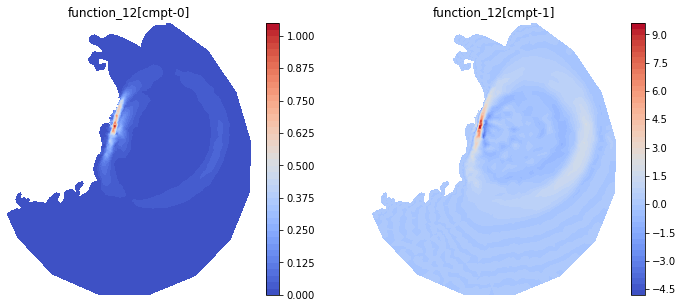

In [16]:
J, q = solve_forward(m0)
plot_fields(*q.split());

### Adjoint problem

The adjoint problem is comprised of the adjoint equations

$$
    -\frac{\partial\mathbf u^*}{\partial t}-b\nabla\eta^*-f\widehat{\mathbf z}\times\mathbf u^*=\boldsymbol0,\qquad
    -\frac{\partial\eta^*}{\partial t}-g\nabla\cdot u^*=\sum_{g\in\mathcal G}\mathbb 1_g(\eta-\eta_g),\qquad
    \text{in}\quad(0,T]\times\Omega,
$$

(using the expressions for $\frac{\partial J}{\partial\mathbf u}$ and $\frac{\partial J}{\partial\eta}$ stated earlier) and the final time and boundary conditions

$$
    \mathbf u^*\cdot\widehat{\mathbf n}|_{\partial\Omega\backslash\Gamma_D}\equiv0,\qquad
    \eta^*|_{\partial\Omega\backslash\Gamma_{\mathrm{freeslip}}}\equiv0,\qquad
    \mathbf u^*|_{t=T}\equiv\boldsymbol0,\qquad
    \eta^*|_{t=T}\equiv0.
$$

Recall that in our case $\partial\Omega\backslash\Gamma_{\mathrm{freeslip}}=\emptyset$ and $\partial\Omega\backslash\Gamma_D$ corresponds to coastal boundary tags 200 and 300.

In [17]:
def solve_adjoint(gradient=True, debug=True):
    print("ADJOINT SOLVE FOR GRADIENT CALCULATION" if gradient else "ADJOINT SOLVE")
    
    # --- Setup function spaces
    
    fs = VectorFunctionSpace(mesh, "CG", 2)*FunctionSpace(mesh, "CG", 1)
    P0 = FunctionSpace(mesh, "DG", 0)
    
    # -- Setup fields
    
    b, f, g = get_fields(fs)
    
    # --- Setup PDE

    dtc = Constant(op.dt)
    
    u_star, eta_star = TrialFunctions(fs)
    z, zeta = TestFunctions(fs)
    q_star_ = Function(fs)
    u_star_, eta_star_ = q_star_.split()

    a = -inner(z, u_star)*dx - inner(zeta, eta_star)*dx
    L = -inner(z, u_star_)*dx - inner(zeta, eta_star_)*dx

    n = FacetNormal(mesh)

    def G(uv_star, elev_star):
        F = -b*inner(z, grad(elev_star))*dx
        F += -f*inner(z, as_vector((-uv_star[1], uv_star[0])))*dx
        F += g*inner(grad(zeta), uv_star)*dx
        for tag in boundary_conditions:
            if 'dirichlet' in boundary_conditions[tag]:
                F += -inner(zeta*n, uv_star)*ds(tag)
        return F

    a += 0.5*dtc*G(u_star, eta_star)
    L += -0.5*dtc*G(u_star_, eta_star_)

    rhs = Function(fs.sub(1))

    L += zeta*rhs*dx

    q_star = Function(fs)
    u_star, eta_star = q_star.split()

    # bc = DirichletBC(fs.sub(1), 0, [200, 300])
    bc = None
    bcs = []
    for tag in boundary_conditions:
        if 'freeslip' not in boundary_conditions[tag]:
            bcs.append(DirichletBC(fs.sub(1), 0, tag))

    params = {
        "snes_type": "ksponly",
        "ksp_type": "gmres",
        "pc_type": "fieldsplit",
        "pc_fieldsplit_type": "multiplicative",
    }

    problem = LinearVariationalProblem(a, L, q_star, bcs=bc)
    solver = LinearVariationalSolver(problem, solver_parameters=params)
    
    # --- Setup indicators
    
    radius = 20.0e+03*pow(0.5, level)  # The finer the mesh, the more precise the indicator region
    for gauge in op.gauges:
        op.gauges[gauge]['indicator'] = interpolate(ellipse([op.gauges[gauge]["coords"] + (radius,), ], mesh), P0)
    
    # --- Time integrate
    
    t = op.end_time
    iteration = int(op.end_time/op.dt)
    tic = clock()
    msg = "    simulation time {:4.1f} minutes    wallclock time {:4.1f} seconds"
    while t > 0.0:
        if iteration % 48 == 0:
            toc = clock() - tic
            print_debug(msg.format(t/60, toc), debug=debug)
            tic = clock()

        # Evaluate function appearing in RHS
        assert diffs[iteration] is not None
        rhs.interpolate(diffs[iteration])
        diffs[iteration] = None  # Reset saved data

        # Solve adjoint equation at current timestep
        solver.solve()

        # Increment
        q_star_.assign(q_star)
        t -= op.dt
        iteration -= 1

    assert np.allclose(t, 0.0)
    toc = clock() - tic
    print_debug(msg.format(t/60, toc), debug=debug)
    return q_star

Let's take a look at the adjoint solution.

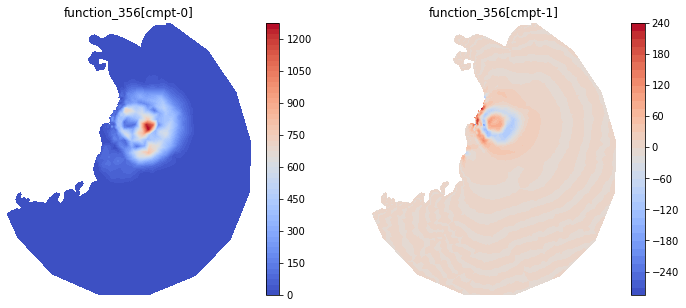

In [21]:
q_star = solve_adjoint()
plot_fields(*q_star.split());

Further, recall that the gradient may be computed as

$$
    \frac{\mathrm dJ}{\mathrm dm_k} = \int_\Omega g_k\eta^*|_{t=0}\;\mathrm dx
    +\int_\Omega\sigma m_k\nabla g_k\cdot\nabla g_k\;\mathrm dx.
$$

In [22]:
def gradient(m, debug=True):
    if isinstance(m, float):
        m = [m, ]
    if diffs[-1] is None:
        J, q = solve_forward(m, gradient=True, debug=debug)
    adj_sol0 = solve_adjoint(debug=debug)
    basis_functions = get_basis_functions(adj_sol0.function_space())
    g = np.array([assemble(inner(adj_sol0, phi)*dx) for phi in basis_functions])
    basis_derivatives = [m_i*grad(phi_i.split()[1]) for m_i, phi_i in zip(m, basis_functions)]
    g += np.array([assemble(sigma*m_i*(d_i[0]**2 + d_i[1]**2)*dx) for m_i, d_i in zip(m, basis_derivatives)])
    
    print_debug("Gradient = {:.8e}".format(g[0]), debug=debug)
    return g

## Taylor Test

To check that the gradient is consistent, we can apply a Taylor remainder test.
Denote by $\widehat J=\widehat J(m)$ the reduced functional and consider the first order Taylor remainder

$$
    T_1(h):=\left|\:\widehat J(m+h\delta m) - \widehat J(m)\:\right|,
$$

for some search direction $\delta m$ and step length $m$.
In addition, consider the second order Taylor remainder

$$
    T_2(h):=\left|\:\widehat J(m+h\delta m) - \widehat J(m) - h\;\mathrm d\widehat J\cdot\delta m\:\right|.
$$

where we propose that $\mathrm d\widehat J$ is the gradient of $\widehat J$ w.r.t. the control $m$.
Continuity of the reduced functional implies that $\lim_{h\rightarrow0}T_1(h)=0$ at rate $\mathcal O(h)$.
Provided that $\mathrm d\widehat J$ is indeed the gradient, we also have that $\lim_{h\rightarrow0}T_2(h)=0$.
Moreover, we expect that this convergence is achieved at rate $\mathcal O(h^2)$.

The Taylor test simply verifies that the second order convergence is achieved.

In [23]:
def taylor_test(m, delta_m=0.1, h_init=1):
    print(20*"=" + "TAYLOR TEST" + 20*"=")
    if isinstance(m, float):
        m = [m, ]
    if isinstance(delta_m, float):
        delta_m = [delta_m, ]
    m = np.array(m)
    delta_m = np.array(delta_m)
    
    # Evaluate the reduced functional and gradient at the specified control value
    Jm = reduced_functional(m)
    dJm = gradient(m)
    
    # Check that the Taylor remainders decrease quadratically
    remainders = np.zeros(3)
    for i in range(3):
        h = h_init*pow(0.5, i)
        print("h = {:.4e}".format(h))
        J_step = reduced_functional(m+h*delta_m)
        diff = J_step - Jm
        grad_h = h*np.dot(dJm, delta_m)
        print("Difference = {:.4e}".format(diff))
        print("Gradient = {:.4e}".format(grad_h))
        remainders[i] = abs(diff - grad_h)
        print("Taylor remainder = {:.4e}".format(remainders[i]))
        if i > 0:
            ratio = remainders[i-1]/remainders[i]
            try:
                assert ratio > 1.95
            except AssertionError:
                msg = "Taylor remainders do not decrease quadratically (ratio {:.4e})"
                raise ConvergenceError(msg.format(ratio))
    print(16*"=" + "TAYLOR TEST PASSED!" + 16*"=")

In [24]:
taylor_test(4.5)

====================TAYLOR TEST====================
FORWARD SOLVE
Current control value = 4.50000000e+00
    simulation time  0.0 minutes    wallclock time  0.0 seconds
    simulation time  4.0 minutes    wallclock time 20.6 seconds
    simulation time  8.0 minutes    wallclock time 19.5 seconds
    simulation time 12.0 minutes    wallclock time 19.7 seconds
    simulation time 16.0 minutes    wallclock time 19.4 seconds
    simulation time 20.0 minutes    wallclock time 19.6 seconds
    simulation time 24.0 minutes    wallclock time 20.1 seconds
    Quantity of interest = 6.52032091e+13
ADJOINT SOLVE FOR GRADIENT CALCULATION
    simulation time 24.0 minutes    wallclock time  0.0 seconds
    simulation time 20.0 minutes    wallclock time 13.5 seconds
    simulation time 16.0 minutes    wallclock time 13.9 seconds
    simulation time 12.0 minutes    wallclock time 13.5 seconds
    simulation time  8.0 minutes    wallclock time 13.4 seconds
    simulation time  4.0 minutes    wallclock 

## Parameter space exploration

Since we have a one-dimensional control parameter space, we can easily explore the parameter space to see how it looks.

In [27]:
sigma.assign(1.0e+10);

In [28]:
n = 9
control_values = np.linspace(2.0, 10.0, n)
# func_values = np.zeros(n)
# for i, m in enumerate(control_values):
#     func_values[i] = reduced_functional(m, debug=False)
#     print("{:2d}: control value {:.4e}  functional value {:.4e}".format(i, m, func_values[i]))
    
# Here's one I prepared earlier
assert sigma.dat.data[0] == 1.0e+10
func_values = np.array([6.7522e+13, 6.6670e+13, 6.6147e+13, 6.5954e+13, 6.6090e+13, 6.6556e+13,
                        6.7352e+13, 6.8477e+13, 6.9932e+13])

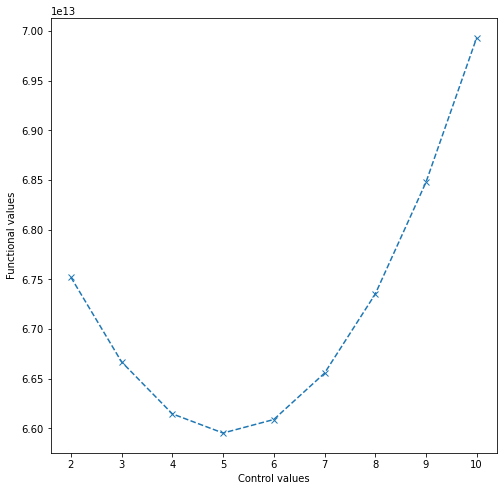

In [29]:
fig, axes = plt.subplots(figsize=(8, 8))

axes.plot(control_values, func_values, '--x')
axes.set_xlabel("Control values");
axes.set_ylabel("Functional values");

This plot will be very useful in interpreting the progress of the minimisation routine.

## Inversion for a single basis function coefficient

Now that we have functions for solving the forward problem and computing the gradient, we can apply a quasi-Newton optimisation method such as BFGS to optimise the control parameter.
BFGS may be expressed in pseudocode as

* Choose initial guess $m_0$
* $i:=0$
* while not converged:
    - solve forward problem with control $m_i$ to evaluate QoI as $J_i$
    - solve adjoint problem
    - compute gradient $g_i$ for control $m_i$
        
    - Approximate Hessian:
        * if $i = 0$ then $H_i:=I$
        * else:
            - $s := m_i - m_{i-1}$
            - $y := g_i - g_{i-1}$
            - $H_i := \left(I - \frac{sy^T}{y^Ts}\right) H_{i-1} \left(I - \frac{ys^T}{y^Ts}\right) + \frac{ss^T}{y^Ts}$
            
    - compute search direction $p_i := H_ig_i$
    - compute step length $\alpha_i$ using line search
    - take step $m_{i+1} := m_i + \alpha_ip_i$
    - check convergence
    - $i = i+1$
        
where $I$ is the identity matrix and each $m_i$ is a vector of control parameters.

Note that this "bad Broyden" version of BFGS (which approximates the inverse Hessian rather than the Hessian itself) is known to be sensitive to the scaling of the gradient.
Since the gradient values are $\mathcal O(10^{11})$ for this problem, we rescale it.

In [ ]:
m_init = np.array([9.0, ])

# scaling = 1.0e-13
scaling = 1.0
control_values_opt = []
func_values_opt = []
gradient_values_opt = []

def scaled_reduced_functional(m):
    J = scaling*reduced_functional(m, debug=False)
    control_values_opt.append(m[0])
    func_values_opt.append(J)
    return J

def scaled_gradient(m):
    if diffs[0] is None:
        J = scaled_reduced_functional(m)
        control_values_opt.append(m[0])
        func_values_opt.append(J)
    else:
        J = func_values_opt[-1]
    adj_sol0 = solve_adjoint(debug=False)
    adj_sol0 *= -1  # FIXME
    basis_functions = get_basis_functions(adj_sol0.function_space())
    g = scaling*np.array([assemble(inner(adj_sol0, phi)*dx) for phi in basis_functions])
    gradient_values_opt.append(g[0])
    print("control {:.8e}  functional {:.8e}  gradient {:.8e}".format(m[0], J, g[0]))
    return g

def opt_cb(m_current):
    print("LINE SEARCH COMPLETE\n")

opt_parameters = {
    'maxiter': 5,
    'disp': True,
#     'gtol': 1.0e-02,
    'gtol': 1.0,
    'callback': opt_cb,
    'retall': True,
}

m_opt = scipy.optimize.fmin_bfgs(scaled_reduced_functional, m_init, fprime=scaled_gradient, **opt_parameters)
print("Optimised control parameter = {:.4e}".format(*m_opt))

FORWARD SOLVE
ADJOINT SOLVE FOR GRADIENT CALCULATION
control 9.00000000e+00  functional 6.84771528e+13  gradient 4.08252912e+11
FORWARD SOLVE
ADJOINT SOLVE FOR GRADIENT CALCULATION
control 7.99000000e+00  functional 6.73422956e+13  gradient 3.62691582e+11
LINE SEARCH COMPLETE

FORWARD SOLVE
ADJOINT SOLVE FOR GRADIENT CALCULATION
control 1.66944696e+00  functional 6.78765300e+13  gradient 7.75699903e+10
FORWARD SOLVE
ADJOINT SOLVE FOR GRADIENT CALCULATION
control 6.66473456e+00  functional 6.63632596e+13  gradient 3.02908555e+11
LINE SEARCH COMPLETE

FORWARD SOLVE
ADJOINT SOLVE FOR GRADIENT CALCULATION
control 1.35857052e-01  functional 6.99912893e+13  gradient 8.38939934e+09
FORWARD SOLVE
ADJOINT SOLVE FOR GRADIENT CALCULATION
control 6.20038781e+00  functional 6.61571815e+13  gradient 2.81961767e+11
FORWARD SOLVE
ADJOINT SOLVE FOR GRADIENT CALCULATION
control 6.08668860e+00  functional 6.61175534e+13  gradient 2.76832770e+11
FORWARD SOLVE
ADJOINT SOLVE FOR GRADIENT CALCULATION


Let's view the progress of the optimisation routine superimposed on the sample of the parameter space explored previously.

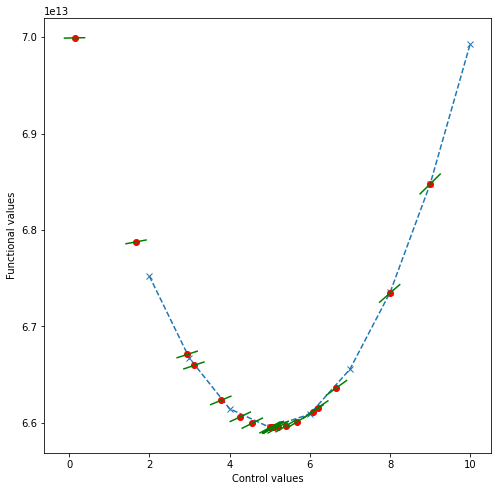

In [24]:
fig, axes = plt.subplots(figsize=(8, 8))

axes.plot(control_values, scaling*func_values, '--x')
axes.plot(control_values_opt, func_values_opt, 'o', color='r')

delta_m = 0.25
for m, f, g in zip(control_values_opt, func_values_opt, gradient_values_opt):
    x = np.array([m - delta_m, m + delta_m])
    axes.plot(x, g*(x-m) + f, '-', color='g')

axes.set_xlabel("Control values");
axes.set_ylabel("Functional values");
# axes.set_xlim([3, 10]);
# axes.set_ylim([scaling*6.45e+13, scaling*6.65e+13]);
# axes.set_ylim([scaling*3.8e+12, scaling*4.2e+12]);